In [3]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img
import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA
import scipy.sparse as sp
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.stats import zscore
from scipy.io import loadmat
from scipy import ndimage

In [1]:
ses = 1
sub = '04'
run = 1
num_trials = 90
trial_len = 9

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'
anat_path = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz'
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
mask_base = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat'

behaviour_metric_names = ("PT", "RT", "MT", "RT+MT", "Vmax", "Pmax")
if ses == 1:
    behave_path = f"/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD0{sub}_OFF_behav_metrics.mat"
else:
    behave_path = f"/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD0{sub}_ON_behav_metrics.mat"


Loading Datasets and Masks

In [3]:
anat_img = nib.load(anat_path) 

BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

brain_mask_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
brain_mask_img = nib.load(brain_mask_path)
back_mask = brain_mask_img.get_fdata()

csf_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
csf_mask = nib.load(csf_path).get_fdata()

wm_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
white_mask = nib.load(wm_path).get_fdata()

Apply Masks on Bold Dataset

In [4]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
white_mask_data = white_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)

white_mask_flat = white_mask_data[nonzero_mask]
keep_voxels = ~white_mask_flat

bold_flat = bold_data[nonzero_mask]
masked_bold = bold_flat[keep_voxels]
masked_coords = tuple(ax[keep_voxels] for ax in nonzero_mask)

Remove voxels in CSF & brain mask from the bold data

In [5]:

masked_bold = masked_bold.astype(np.float32)
num_voxels, num_timepoints = masked_bold.shape
bold_data_reshape = np.full((num_voxels, num_trials, trial_len), np.nan, dtype=np.float32)

start = 0
for i in range(num_trials):
    end = start + trial_len
    if end > num_timepoints:
        raise ValueError("Masked BOLD data does not contain enough timepoints for all trials")
    bold_data_reshape[:, i, :] = masked_bold[:, start:end]
    start += trial_len
    if start in (270, 560):
        start += 20  # skip discarded timepoints

Load Beta values

Load the filtered beta values

In [6]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR_sub{sub}.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]

if run == 1:
    beta = beta_run1[keep_voxels]
else:
    beta = beta_run2[keep_voxels]

nan_voxels = np.isnan(beta).all(axis=1)
if np.any(nan_voxels):
    beta = beta[~nan_voxels]
    bold_data_reshape = bold_data_reshape[~nan_voxels]
    masked_coords = tuple(coord[~nan_voxels] for coord in masked_coords)

# # remove last trial which have most of NaN values. 
# bold_data_reshape = bold_data_reshape[:,:-1,:]
# beta = beta[:,:-1]

Load the filtered beta values

Load the filtered beta values

Normalize beta value / NaN trials with extremely different beta values

In [10]:
med = np.nanmedian(beta, keepdims=True)
mad = np.nanmedian(np.abs(beta - med), keepdims=True)
scale = 1.4826 * np.maximum(mad, 1e-9)    
beta_norm = (beta - med) / scale      
thr = np.nanpercentile(np.abs(beta_norm), 99.9)
outlier_mask = np.abs(beta_norm) > thr  


clean_beta = beta.copy()
voxel_outlier_fraction = np.mean(outlier_mask, axis=1)
valid_voxels = voxel_outlier_fraction <= 0.5
clean_beta[~valid_voxels] = np.nan
clean_beta[np.logical_and(outlier_mask, valid_voxels[:, None])] = np.nan
keeped_mask = ~np.all(np.isnan(clean_beta), axis=1)
clean_beta = clean_beta[keeped_mask]
keeped_indices = np.flatnonzero(keeped_mask)

bold_data_reshape[~valid_voxels, :, :] = np.nan
trial_outliers = np.logical_and(outlier_mask, valid_voxels[:, None])
bold_data_reshape = np.where(trial_outliers[:, :, None], np.nan, bold_data_reshape)
bold_data_reshape = bold_data_reshape[keeped_mask]

In [12]:
clean_beta.shape

(619244, 90)

In [11]:
bold_data_reshape.shape

(619244, 90, 9)

In [13]:
beta_nan = np.isnan(clean_beta)                        # (voxels, trials)
bold_nan = np.isnan(bold_data_reshape).all(axis=-1)    # collapse time axis → (voxels, trials)

print("Mismatch count:", np.count_nonzero(beta_nan != bold_nan))
if np.any(beta_nan != bold_nan):
    vox_idx, trial_idx = np.nonzero(beta_nan != bold_nan)
    print("First mismatches:", list(zip(vox_idx[:10], trial_idx[:10])))
else:
    print("Beta and BOLD NaN trials line up.")


Mismatch count: 0
Beta and BOLD NaN trials line up.


Apply t-test and FDR, detect & remove non-active voxels

In [8]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_idx = keeped_indices[reject]
clean_active_bold = bold_data_reshape[reject]

/home/zkavian/.venvs/workspace/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:634: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


In [9]:
num_trials = beta.shape[-1]
clean_active_volume = np.full(bold_data.shape[:3]+(num_trials,), np.nan)
active_coords = tuple(coord[clean_active_idx] for coord in masked_coords)
clean_active_volume[active_coords[0], active_coords[1], active_coords[2], :] = clean_active_beta

apply filter

In [10]:
# def hampel_filter_image(image, window_size, threshold_factor, return_stats=False):
#     filtered = image.astype(float).copy()
#     footprint = np.ones((window_size,) * 3, dtype=bool)

#     insufficient_counts = []
#     corrected_indices_parts = []

#     for t in range(image.shape[3]):
#         print(f"Trial Number: {t}")
#         vol = image[..., t]
#         valid = np.isfinite(vol)

#         med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         counts = ndimage.generic_filter(np.isfinite(vol).astype(np.float32), np.sum, footprint=footprint, mode='constant', cval=0)
#         neighbor_count = counts - valid.astype(np.float32)

#         scaled_mad = 1.4826 * mad
#         insufficient = valid & (neighbor_count < 3)
#         insufficient_counts.append(int(np.count_nonzero(insufficient)))
#         filtered[..., t][insufficient] = np.nan

#         enough_data = (neighbor_count >= 3) & valid
#         outliers = enough_data & (np.abs(vol - med) > threshold_factor * scaled_mad)

#         if np.any(outliers):
#             coords = np.argwhere(outliers)
#             t_column = np.full((coords.shape[0], 1), t, dtype=int)
#             corrected_indices_parts.append(np.hstack((coords, t_column)))

#         filtered[..., t][outliers] = med[outliers]

#     if return_stats:
#         insufficient_counts_arr = np.array(insufficient_counts, dtype=int)
#         if corrected_indices_parts:
#             corrected_indices = np.vstack(corrected_indices_parts)
#         else:
#             corrected_indices = np.empty((0, 4), dtype=int)

#         stats = {
#             'insufficient_counts': insufficient_counts_arr,
#             'insufficient_total': int(insufficient_counts_arr.sum()),
#             'corrected_indices': corrected_indices,
#             'corrected_total': int(corrected_indices.shape[0]),
#         }
#         return filtered, stats

#     return filtered

# beta_volume_filter, hampel_stats = hampel_filter_image(clean_active_volume, window_size=5, threshold_factor=3, return_stats=True)
# print('Insufficient neighbours per frame:', hampel_stats['insufficient_counts'], flush=True)
# print('Total voxels with <3 neighbours:', hampel_stats['insufficient_total'], flush=True)
# print('Total corrected voxels:', hampel_stats['corrected_total'], flush=True)

# beta_volume_filter = beta_volume_filter[~np.all(np.isnan(beta_volume_filter), axis=-1)]
# np.save(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy', beta_volume_filter)


Load the filtered beta values

In [10]:
beta_valume_clean_2d = np.load(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy')
mask_2d = np.load("mask_all_nan_sub04_ses1_run1.npy")


active_flat_idx = np.ravel_multi_index(active_coords, clean_active_volume.shape[:3])
active_keep_mask = ~mask_2d[active_flat_idx]
clean_active_bold = clean_active_bold[active_keep_mask]

In [46]:
beta_valume_clean_2d.shape

(314734, 90)

Load Behaviour

In [4]:
def load_behavior_metrics(path, run):
    behav_data = loadmat(path)
    behav_metrics = behav_data["behav_metrics"]
    behav_block = np.stack(behav_metrics[0], axis=0)
    _, _, num_metrics = behav_block.shape
    behav_flat = behav_block.reshape(-1, num_metrics)
    if run == 1:
        behav_flat = behav_flat[:90, :6]
    else:
        behav_flat = behav_flat[90:180, :6]
    return behav_flat

behavior_matrix = load_behavior_metrics(behave_path, run)

In [5]:
behave_path

'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD004_OFF_behav_metrics.mat'

PCA (run main_pca.py)

In [6]:
import numpy as np
pca_model = np.load('empca_model_sub04_ses1_run1.npy', allow_pickle=True).item()
pca_model.__dict__.keys()

dict_keys(['eigvec', 'nvec', 'data', 'weights', 'nobs', 'nvar', 'coeff', 'model', 'dof', '_unmasked', '_unmasked_data_var'])

In [7]:
z = pca_model.coeff
z.shape

(314734, 700)

In [8]:
data = pca_model.data
data.shape

(314734, 810)

In [3]:
eigvecs = pca_model.eigvec
eigvecs.shape

(700, 810)

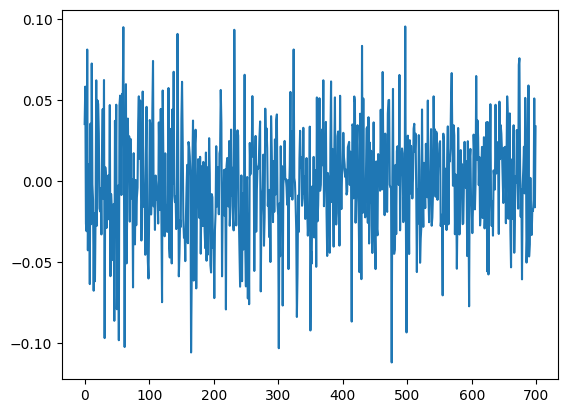

In [9]:
import matplotlib.pyplot as plt
plt.plot(eigvecs[:, 1])

In [ ]:
for i in range(pca_model.nvec):
    print(pca_model.R2vec(i))

In [21]:
# def prepare_for_empca(data):
#     print(data.shape)
#     W = np.isfinite(data).astype(float)
#     Y = np.where(np.isfinite(data), data, 0.0)

#     col_sum = (Y * W).sum(axis=0)
#     print(col_sum.shape)
#     col_count = W.sum(axis=0)
#     col_mean = np.divide(col_sum, col_count, out=np.zeros_like(col_sum), where=col_count>0)
#     Yc = Y - col_mean
#     return Yc, W

def prepare_for_empca(data):
    W = np.isfinite(data).astype(float)
    Y = np.where(np.isfinite(data), data, 0.0)

    row_weight = W.sum(axis=0, keepdims=True)
    mean = np.divide((Y * W).sum(axis=0, keepdims=True), row_weight, out=np.zeros_like(row_weight), where=row_weight > 0)
    centered = Y - mean

    var = np.divide((W * centered**2).sum(axis=0, keepdims=True), row_weight, out=np.zeros_like(row_weight), where=row_weight > 0)
    scale = np.sqrt(var)

    z = np.divide(centered, np.maximum(scale, 1e-6), out=np.zeros_like(centered), where=row_weight > 0)
    return z, W

In [22]:
trial_indices=None
trial_len=trial_len 
pca_components=None 
pca_mean=None

num_trials = beta_valume_clean_2d.shape[-1]
trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())
behavior_subset = behavior_matrix[trial_idx]
X_bold = clean_active_bold[:, trial_idx, :]

# ----- apply PCA -----
print("PCA...", flush=True)
X_reshap = X_bold.reshape(X_bold.shape[0], -1)
X_reshap.shape

PCA...


(314734, 810)

In [ ]:
W.shape

(810, 314734)

In [23]:
Yc, W = prepare_for_empca(X_reshap.T)

from empca.empca import empca
# m = empca(Yc, W, nvec=600)

In [ ]:
z = m.coeff
z.shape

In [45]:
tmp = np.isnan(X_reshap.T)
np.where(tmp==True)

(array([], dtype=int64), array([], dtype=int64))

In [41]:
tmp.shape

(810, 314734)

In [35]:
type(W)

numpy.ndarray

In [ ]:
W.shape

(810, 314734)

In [24]:
W.shape

(810, 314734)

In [25]:
Yc.shape

(810, 314734)

In [ ]:
# per-component variance explained
for i in range(m.eigvec.shape[1]):
    print(f"PC{i+1} R2 = {m.R2vec(i):.4f}")

In [12]:
import numpy as np
m = np.load('empca_model_sub04_ses1_run1.npy', allow_pickle=True).item()

In [16]:
m.__dict__.keys()

dict_keys(['eigvec', 'nvec', 'data', 'weights', 'nobs', 'nvar', 'coeff', 'model', 'dof', '_unmasked', '_unmasked_data_var'])

In [22]:
m.eigvec.shape

(600, 314734)

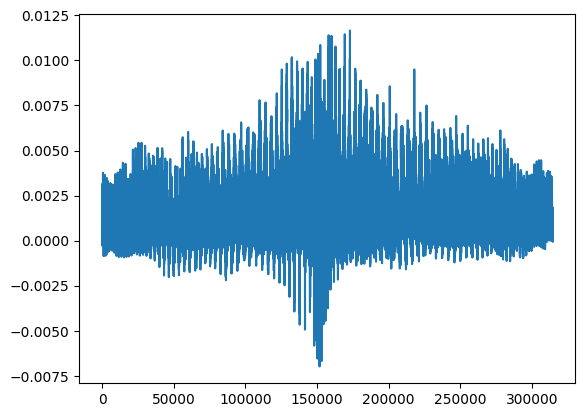

In [23]:
import matplotlib.pyplot as plt

plt.plot(m.eigvec[0,:], label='PC1')

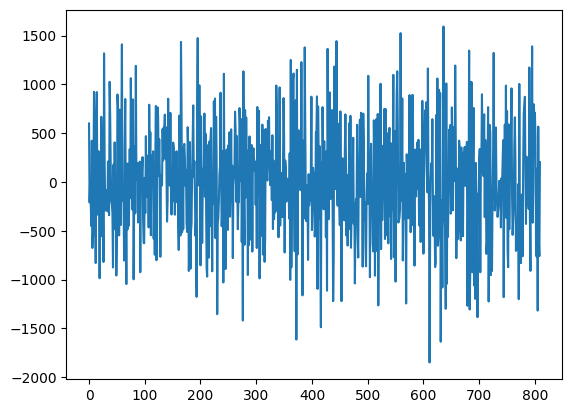

In [ ]:
import matplotlib.pyplot as plt

plt.plot(m.coeff[:,599], label='PC1')

In [ ]:
# add code to generate BOLD, Beta, Behaviour Data in PCA space

In [ ]:
# check dimension of variables below

In [ ]:
def matrices_func(beta_pca, bold_pca, behave_pca, mask_2d, trial_indices=None, trial_len=trial_len, num_trials=90):
    # reshape beta_pca, bold_pca, behave_pca if it is necessary
    bold_pca_reshape = bold_pca.reshape(bold_pca.shape[0], num_trials, trial_len)

    trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())

    # select trials
    behavior_selected = behave_pca[trial_idx]
    beta_selected = beta_pca[:, trial_idx]

    # ----- L_task (same idea as yours) -----
    print("L_task...", flush=True)
    counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
    sums = np.nansum(np.abs(beta_selected), axis=-1, dtype=np.float32)
    mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
    m = counts > 0
    mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)

    L_task = np.zeros_like(mean_beta, dtype=np.float32)
    v = np.abs(mean_beta) > 0 # avoid division by zero
    L_task[v] = (1.0 / mean_beta[v]).astype(np.float32)

    # ----- L_var_bold: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    L_var_bold = np.zeros((bold_pca_reshape.shape[0], bold_pca_reshape.shape[0]), dtype=np.float32)

    for i in range(num_trials-1):
        x1 = bold_pca_reshape[:, i, :]
        x2 = bold_pca_reshape[:, i+1, :]
        L_var_bold += (x1-x2) @ (x1-x2).T
    L_var_bold /= (num_trials - 1)

    # ----- L_behavior: derived from behaviour regression weights -----
    print("L_behavior...", flush=True)
    L_behavior = np.zeros_like(behavior_selected, dtype=np.float32)
    valid_behav = np.isfinite(behavior_selected)
    L_behavior[valid_behav] = (1.0 / np.abs(behavior_selected[valid_behav])).astype(np.float32)

    # ----- L_var_beta: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    L_var_beta = np.zeros((beta_selected.shape[0], beta_selected.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = beta_selected[:, i]
        x2 = beta_selected[:, i+1]
        diff = x1 - x2
        L_var_beta += np.outer(diff, diff)  
    L_var_beta /= (num_trials - 1)

    return L_task, L_var_bold, L_var_beta, L_behavior

In [ ]:
def optm_func(L_task, L_var_bold, L_var_beta, alpha_bold, alpha_beta, L_behavior, alpha_beh, grad_norm_iters=5):
    print("Optimizing voxel weights...", flush=True)

    (L_task_scaled, L_var_bold_scaled, L_var_beta_scaled, L_behavior_scaled) = _normalize_terms(L_task, L_var_bold, L_var_beta, L_behavior)

    # lambda_floor = 3e-2
    # if L_var_beta_scaled.ndim == 2:
    #     L_var_beta_scaled = L_var_beta_scaled + lambda_floor * np.eye(L_var_beta_scaled.shape[0], dtype=L_var_beta.dtype)
    # else:
    #     L_var_beta_scaled = L_var_beta_scaled + lambda_floor

    L_task_diag = np.diag(L_task_scaled)
    L_behavior_diag = np.diag(L_behavior_scaled)
    

    L_total = L_task_diag + alpha_bold * L_var_bold_scaled + alpha_beta * L_var_beta_scaled + alpha_beh * L_behavior_diag
    print(f"Is there any NaN in L_total? {np.isnan(L_total).any()}", flush=True)
    L_total = 0.5 * (L_total + L_total.T)
    L_total += 1e-8 * np.eye(L_total.shape[0])
    print(f"range L_total: {np.min(L_total)}, {np.max(L_total)}", flush=True)

    w_var = cp.Variable(L_total.shape[0], nonneg=True)
    constraints = [cp.sum(w_var) == 1]
    objective = cp.Minimize(cp.quad_form(w_var, cp.psd_wrap(L_total)))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)

    return w_var.value